In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import shap
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [10]:
from sklearn.datasets import load_boston

boston = load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)

df['target'] = boston.target

df.shape



(506, 14)

In [11]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [12]:
X , y = df.drop('target', axis=1), df['target']

In [13]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

model = RandomForestRegressor(random_state=123)

fit = model.fit(X_train, y_train)

yhat = fit.predict(X_test)

mse = mean_squared_error(y_test, yhat)

print('MSE:', round(mse, 4))
print('RMSE:', round(np.sqrt(mse), 4))

MSE: 14.0275
RMSE: 3.7453


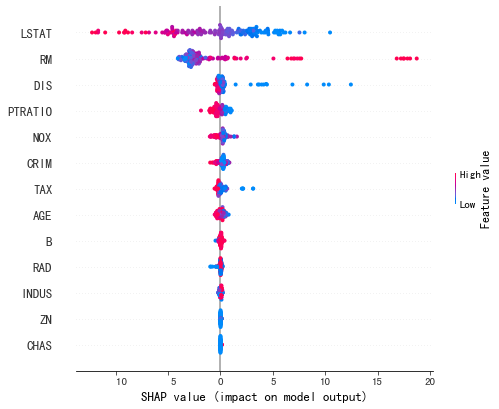

In [15]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [16]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=123)

ix_training, ix_test = [], []

for fold in cv.split(df):
    ix_training.append(fold[0]), ix_test.append(fold[1])

In [30]:
SHAP_value_per_fold = []

for i , (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
    print('\n---- Fold Number:', i)
    X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
    y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]
    
    model = RandomForestRegressor(random_state=123)
    fit = model.fit(X_train, y_train)
    yhat = fit.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    print('MSE:', round(mse, 4))
    print('RMSE:', round(np.sqrt(mse), 4))
    
    explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X_test)
    
    for SHAPs in shap_values:
        SHAP_value_per_fold.append(SHAPs)
    




---- Fold Number: 0
MSE: 17.9589
RMSE: 4.2378

---- Fold Number: 1
MSE: 11.7922
RMSE: 3.434

---- Fold Number: 2
MSE: 7.5039
RMSE: 2.7393

---- Fold Number: 3
MSE: 5.6417
RMSE: 2.3752

---- Fold Number: 4
MSE: 11.3893
RMSE: 3.3748


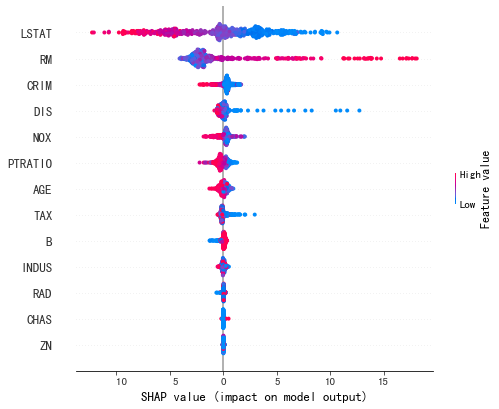

In [31]:
new_index = [ix for ix_test_fold in ix_test for ix in ix_test_fold]

shap.summary_plot(np.array(SHAP_value_per_fold), X.reindex(new_index))

In [52]:
np.random.seed(123)

CV_repeats = 2

random_states = np.random.randint(10000, size=CV_repeats)

shap_values_per_cv = dict()

# for sample in X.index:
#     shap_values_per_cv[sample] = {}
#     for CV_repeat in range(CV_repeats):
#         shap_values_per_cv[sample][CV_repeat] = {}


In [58]:
np.random.seed(123)

CV_repeats = 10

random_states = np.random.randint(10000, size=CV_repeats)

shap_values_per_cv = dict()


for i , CV_repeat in enumerate(range(CV_repeats)):
    print('\n--------- CV Repeat number: ', CV_repeat)
    CV = KFold(n_splits=5, shuffle=True, random_state=random_states[i])
    
    ix_training, ix_test = [], []
    
    for fold in CV.split(df):
        ix_training.append(fold[0]), ix_test.append(fold[1])
        
    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
        print('\n-------- Fold Number: ', i)
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]
        
        model =  RandomForestRegressor(random_state=123)
        fit = model.fit(X_train , y_train)
        yhat = fit.predict(X_test)
        mse = mean_squared_error(y_test, yhat)
        print('RMSE:', round(np.sqrt(mse), 4))
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        for i , test_index in enumerate(test_outer_ix):
            shap_values_per_cv[test_index][CV_repeat] = shap_values[i]


--------- CV Repeat number:  0

-------- Fold Number:  0
RMSE: 3.44


KeyError: 0

In [59]:
np.random.seed(123)

CV_repeats = 10

random_states = np.random.randint(10000, size=CV_repeats)

shap_values_per_cv = dict()

In [62]:
for i , CV_repeat in enumerate(range(CV_repeats)):
    print('i: ', i)
    print('CV_repeat: ', CV_repeat)

i:  0
CV_repeat:  0
i:  1
CV_repeat:  1
i:  2
CV_repeat:  2
i:  3
CV_repeat:  3
i:  4
CV_repeat:  4
i:  5
CV_repeat:  5
i:  6
CV_repeat:  6
i:  7
CV_repeat:  7
i:  8
CV_repeat:  8
i:  9
CV_repeat:  9


In [63]:
i = 0
CV_repeat = 0

CV = KFold(n_splits=5, shuffle=True, random_state=random_states[i])
    
ix_training, ix_test = [], []
    
for fold in CV.split(df):
    ix_training.append(fold[0]), ix_test.append(fold[1])
        
for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
    print('\n-------- Fold Number: ', i)
    X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
    y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]
        
    model =  RandomForestRegressor(random_state=123)
    fit = model.fit(X_train , y_train)
    yhat = fit.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    print('RMSE:', round(np.sqrt(mse), 4))
        
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
        
    for i , test_index in enumerate(test_outer_ix):
            shap_values_per_cv[test_index][CV_repeat] = shap_values[i]


-------- Fold Number:  0
RMSE: 3.44


KeyError: 0